# How to integrate LangGraph with AutoGen, CrewAI, and other frameworks

LangGraph is a framework for building agentic and multi-agent applications. This includes integrating with other agent frameworks.

This guides shows how to integrate LangGraph with other frameworks. The framework we show off integrating with is AutoGen, but this can easily be done with other frameworks.

At a high level, the way this works is by wrapping the other agent inside a LangGraph node. LangGraph nodes can be anything - arbitrary code. This makes it easy to define an AutoGen (or CrewAI, or LlamaIndex, or other framework) agent and then reference it inside your graph. This allows you to create multi-agent systems where some of the sub-agents are actually defined in other frameworks.

## Setup

In [ ]:
%pip install autogen bs4 langgraph langchain-openai langchain-community

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

## Define AutoGen agent

Here we define our AutoGen agent. From https://github.com/microsoft/autogen/blob/0.2/notebook/agentchat_web_info.ipynb

In [ ]:
import autogen
import os

config_list = [{"model": "gpt-4o", "api_key": os.environ["OPENAI_API_KEY"]}]

llm_config = {
    "timeout": 600,
    "cache_seed": 42,
    "config_list": config_list,
    "temperature": 0,
}

autogen_agent = autogen.AssistantAgent(
    name="assistant",
    llm_config=llm_config,
)

user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "web",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    llm_config=llm_config,
    system_message="Reply TERMINATE if the task has been solved at full satisfaction. Otherwise, reply CONTINUE, or the reason why the task is not solved yet.",
)

---

## Define LangGraph agent

We now define our LangGraph agent. We will create a simple ReAct-style agent with a web search tool

In [ ]:
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

model = ChatOpenAI(model="gpt-4o")
tools = [TavilySearchResults(max_results=1)]
web_search_agent = create_react_agent(
    model, tools, state_modifier="You are an agent specializing in web search"
)

## Create the multi-agent graph

We will now create our multi-agent system combining the AutoGen agent with the LangGraph agent. We can do this by creating a graph that routes user query to the appropriate agent and executes the agent

In [ ]:
from typing import Literal, TypedDict


class Route(TypedDict):
    """Decide where to go next"""

    goto: Literal["web_search_assistant", "coding_assistant"]


def route(state: MessagesState) -> Literal["web_search_assistant", "coding_assistant"]:
    messages = [
        {
            "role": "system",
            "content": "Based on the conversation so far, decide who to call next: web search assistant or coding assistant.",
        }
    ] + state["messages"]
    response = model.with_structured_output(Route).invoke(messages)
    return response["goto"]


def call_autogen_agent(state: MessagesState):
    last_message = state["messages"][-1]
    response = user_proxy.initiate_chat(autogen_agent, message=last_message.content)
    # get the final response from the agent
    content = response.chat_history[-1]["content"]
    return {"messages": AIMessage(content=content)}


builder = StateGraph(MessagesState)
builder.add_conditional_edges(START, route)
builder.add_node("coding_assistant", call_autogen_agent)
builder.add_node("web_search_assistant", web_search_agent)
graph = builder.compile()

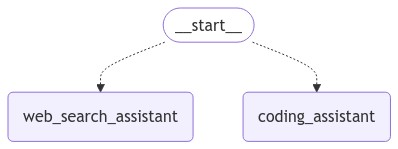

In [14]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Run the graph

We can now run the graph. We can see in the examples below how we first route to the appropriate agent, then respond with the subagent.

In [15]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Find numbers between 10 and 30 in fibonacci sequence",
            }
        ]
    }
):
    print(chunk)

user_proxy (to assistant):

Find numbers between 10 and 30 in fibonacci sequence

--------------------------------------------------------------------------------
assistant (to user_proxy):

To find numbers between 10 and 30 in the Fibonacci sequence, we can generate the Fibonacci sequence and check which numbers fall within this range. Here's a plan:

1. Generate Fibonacci numbers starting from 0.
2. Continue generating until the numbers exceed 30.
3. Collect and print the numbers that are between 10 and 30.

Let's implement this in Python:

```python
# filename: fibonacci_range.py

def fibonacci_sequence():
    a, b = 0, 1
    while a <= 30:
        if 10 <= a <= 30:
            print(a)
        a, b = b, a + b

fibonacci_sequence()
```

Save this code in a file named `fibonacci_range.py` and execute it. It will print the Fibonacci numbers between 10 and 30. TERMINATE

--------------------------------------------------------------------------------
{'coding_assistant': {'messages': A

In [16]:
for chunk in graph.stream(
    {"messages": [{"role": "user", "content": "what's the weather in nyc?"}]},
    subgraphs=True,
):
    print(chunk)

(('web_search_assistant:d08ae326-b6b2-1749-e8ea-4d308f22d819',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wZ5w5uO733Cc4CvWbc4Axq5F', 'function': {'arguments': '{"query":"current weather in New York City"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 96, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0658af11-b90b-407c-a6a5-6a3b4a9f61e0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in New York City'}, 'id': 'call_wZ5w5uO733Cc4CvWbc4Axq5F', 'type': 'tool_call'}], usage_metadat